In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

import numpy as np

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

def printf(string, terminal = False):
    # function for printing stuff that gets removed from the output each iteration
    import sys
    if terminal:
        sys.stdout.write("\r")
        sys.stdout.write(string)
        sys.stdout.flush()
    else:
        from IPython.display import display, clear_output
        clear_output(wait = True)
        print(string, end = '')
        sys.stdout.flush()

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

# Table 32
batch_size = 32

train_dataset = torchvision.datasets.MNIST('../../Neural-Networks/data', train = True, transform = transform)
test_dataset = torchvision.datasets.MNIST('../../Neural-Networks/data', train = False, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

features, labels = next(iter(train_loader))

In [78]:
class BinomialUnit(nn.Module):
    def __init__(self, n_channels: int, in_features: int, out_features: int):
        super().__init__()
        self.batch_normalisation = nn.BatchNorm2d(num_features=n_channels)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.bernoulli_generator = torch.bernoulli
        self.storage = torch.zeros((n_channels, in_features, in_features), device=device)
        self.W = nn.Parameter(torch.empty((n_channels, in_features, out_features))) # synaptic weights
        self.b = nn.Parameter(torch.empty(out_features))
        self.h = nn.Tanh()
        
        # xavier initialisation because of tahn activation
        nn.init.xavier_normal_(self.W)
        nn.init.constant_(self.b, 0.0)
        
        self.n_channels = n_channels
        self.in_features = in_features
        self.out_features = out_features
    
    def forward(self, x, t):
        
        # See Figure 3 on page 8
        x = self.batch_normalisation(x)
        x = self.tanh(x)
        x = self.relu(x)
        x = self.bernoulli_generator(x).detach() - x.detach() + x # STE

        # Accumulation
        x = x + self.storage
        self.storage = x.detach()

        # Unbiased estimator of the expectation
        x = (x / (t + 1))  # Equation 3 on page 4
        
        # Membrane potential
        x = x @ self.W + self.b # Equation 4 on page 4
        
        # Neuron output - Fig 1 Page 5
        x = self.h(x)
        x = torch.clamp(x, 0, 1)
        
        # # Version 1 - Using steep sigmoid
        # random_threshold = torch.rand(1, generator=self.g, device=device)
        # x = self.sigmoid(100 * (x - random_threshold))
        
        # Version 2
        x = self.bernoulli_generator(x).detach() - x.detach() + x # STE
        
        return x

    def reset_storage(self):
        self.storage = torch.zeros((self.n_channels, self.in_features, self.in_features), device=device)

In [79]:
class EConv2d(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        kernel_size: int,
        stride: int = 1,
        padding: int = 0
    ):
        
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.storage = None
        self.sigmoid = nn.Sigmoid()
        
        # Table 2 - Initialise the kernel with he_normal
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(self.conv.bias, 0)
    
    def forward(self, x, t = None):
        x = self.conv(x)
        
        # For conv_initial we only want a convolution, no spiking.
        if t is None:
            return x
        
        if self.storage is None:
            self.storage = torch.zeros_like(x, device=device)
        
        # Squashes to [0, 1]
        x = self.sigmoid(x)
        x = torch.bernoulli(x).detach() - x.detach() + x # STE
        
        # Accumulation
        x = x + self.storage
        self.storage = x.detach()
        
        # Expectation
        x = x / (t + 1)
        
        return x
    
    def reset_storage(self):
        self.storage = None

In [92]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # See Figure 3 on page 8 for the architecture
        self.conv_initial = EConv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1) #[32, 4, 28, 28]
        
        # First layer
        self.BU_11 = BinomialUnit(4, 28, 28)
        self.conv_11 = EConv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1) #[32, 8, 28, 28]
        self.BU_12 = BinomialUnit(8, 28, 28)
        self.conv_12 = EConv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1) #[32, 16, 28, 28]
        
        self.BU_1out = BinomialUnit(16, 28, 28)
        
        # Between first and second
        self.conv_21 = EConv2d(in_channels=16, out_channels=24, kernel_size=3, padding=1) #[32, 24, 28, 28]
        self.BU_21 = BinomialUnit(24, 28, 28)
        self.conv_22 = EConv2d(in_channels=24, out_channels=32, kernel_size=3, padding=1) #[32, 32, 28, 28]
        
        self.conv_23 = EConv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) #[32, 32, 28, 28]
        
        # Second layer
        self.BU_31 = BinomialUnit(32, 28, 28)
        self.conv_31 = EConv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1) #[32, 32, 28, 28]
        self.BU_32 = BinomialUnit(32, 28, 28)
        self.conv_32 = EConv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1) #[32, 32, 14, 14]
        
        self.BU_3out = BinomialUnit(32, 14, 14)
        
        # Between second and third
        self.conv_41 = EConv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1) #[32, 48, 14, 14]
        self.BU_41 = BinomialUnit(48, 14, 14)
        self.conv_42 = EConv2d(in_channels=48, out_channels=64, kernel_size=3, stride=2, padding=1) #[32, 64, 7, 7]
        
        self.conv_43 = EConv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1) #[32, 64, 7, 7]
        
        # Third layer
        self.BU_51 = BinomialUnit(64, 7, 7)
        self.conv_51 = EConv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1) #[32, 64, 7, 7]
        self.BU_52 = BinomialUnit(64, 7, 7)
        self.conv_52 = EConv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1) #[32, 64, 7, 7]
        
        self.BU_5out = BinomialUnit(64, 7, 7)
        
        # Final pooling and dense layer
        self.pool = nn.AvgPool2d(kernel_size=2) #[32, 64, 3, 3]
        self.fc = nn.Linear(64*3*3, 10)
        self.softmax = nn.Softmax(dim = 0)
    
    def forward(self, x_init, T):
        # squash inputs?
        
        x_init = self.conv_initial(x_init)
        
        # First layer
        for t in range(T):
            x = self.BU_11(x_init, t)
            x = self.conv_11(x, t)
            x = self.BU_12(x, t)
            x = self.conv_12(x, t)
        
        x = self.BU_1out(x, t=0)

        # Between first and second layers
        left_x = self.conv_21(x)
        left_x = self.BU_21(left_x, t=0)
        left_x = self.conv_22(left_x)
        
        right_x = self.conv_23(x)
        
        x_init = left_x + right_x
        
        # Second layer
        for t in range(T):
            x = self.BU_31(x_init, t)
            x = self.conv_31(x, t)
            x = self.BU_32(x, t)
            x = self.conv_32(x, t)

        x = self.BU_3out(x, t=0)
        
        # Between second and third layers
        left_x = self.conv_41(x)
        left_x = self.BU_41(left_x, t=0)
        left_x = self.conv_42(left_x)
        
        right_x = self.conv_43(x)
        
        x_init = left_x + right_x
        
        # Third layer
        for t in range(T):
            x = self.BU_51(x_init, t)
            x = self.conv_51(x, t)
            x = self.BU_52(x, t)
            x = self.conv_52(x, t)

        x = self.BU_5out(x, t=0)
        
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x
    
    def test(self):
        print(self.modules())
    
    def reset_storage(self):
        for m in self.modules():
            if isinstance(m, EConv2d) or isinstance(m, BinomialUnit):
                m.reset_storage()
    
model = Network().to(device)
# See table 2 on page 9
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()

In [87]:
n_epochs = 250
T = 3
losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)
        
        outputs = model(features, T)
        loss = criterion(outputs, labels) # Algorithm on page 7 line 17

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.reset_storage()
        
        epoch_loss += loss.item()
        if (i+1) % 100 == 0:
            printf(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    losses += [epoch_loss]

Epoch [10/10], Step [1800/1875], Loss: 2.3024

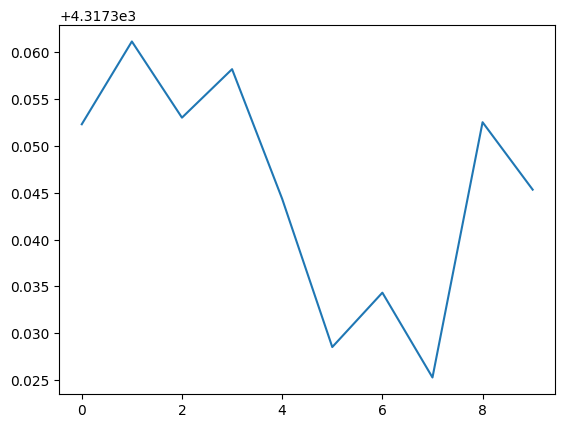

In [88]:
plt.plot(torch.arange(n_epochs), losses)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='mps:0', grad_fn=<SumBackward1>)